In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

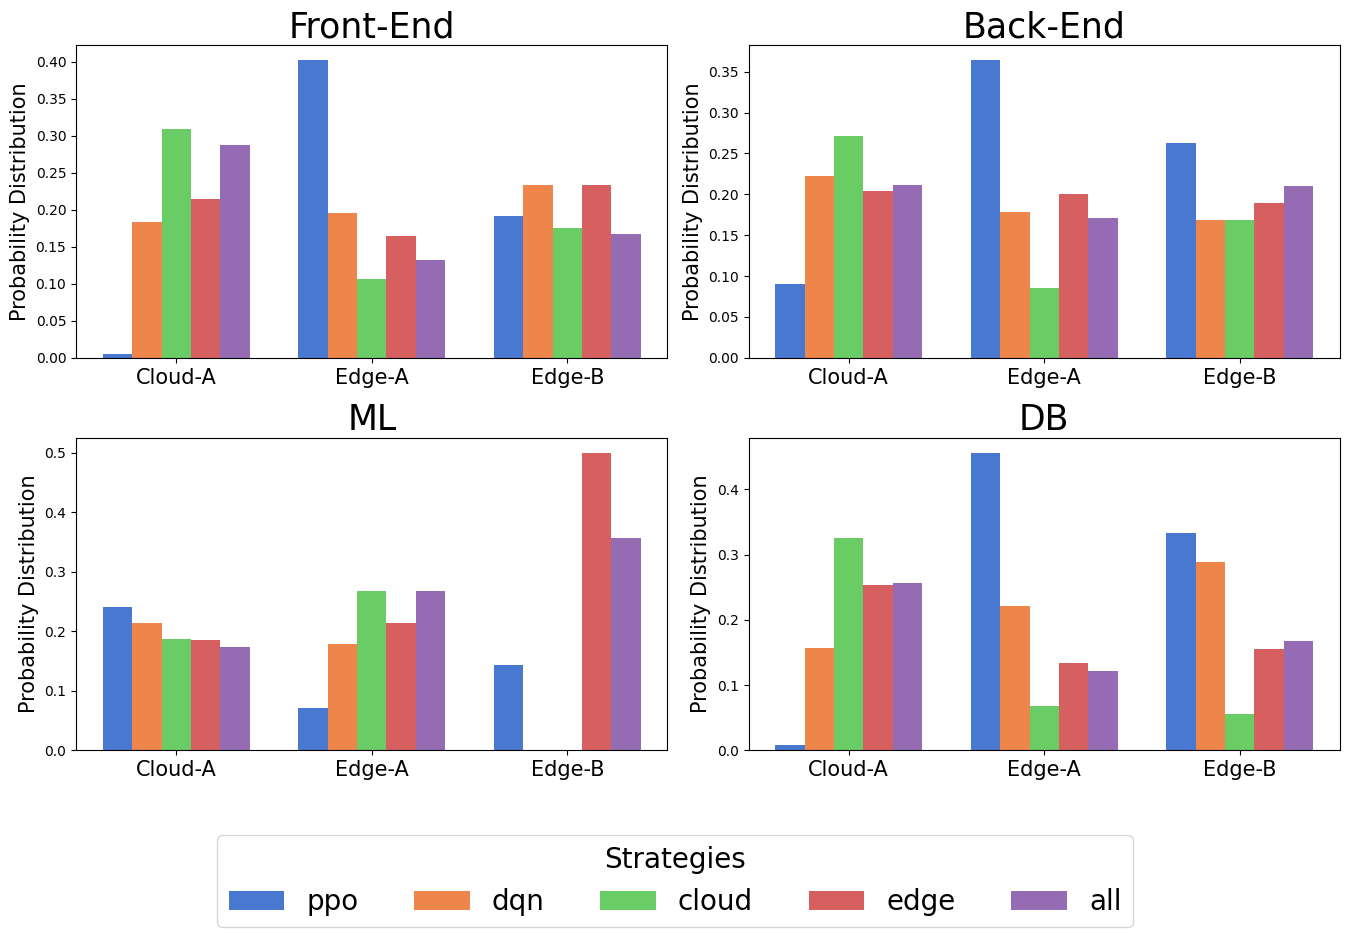

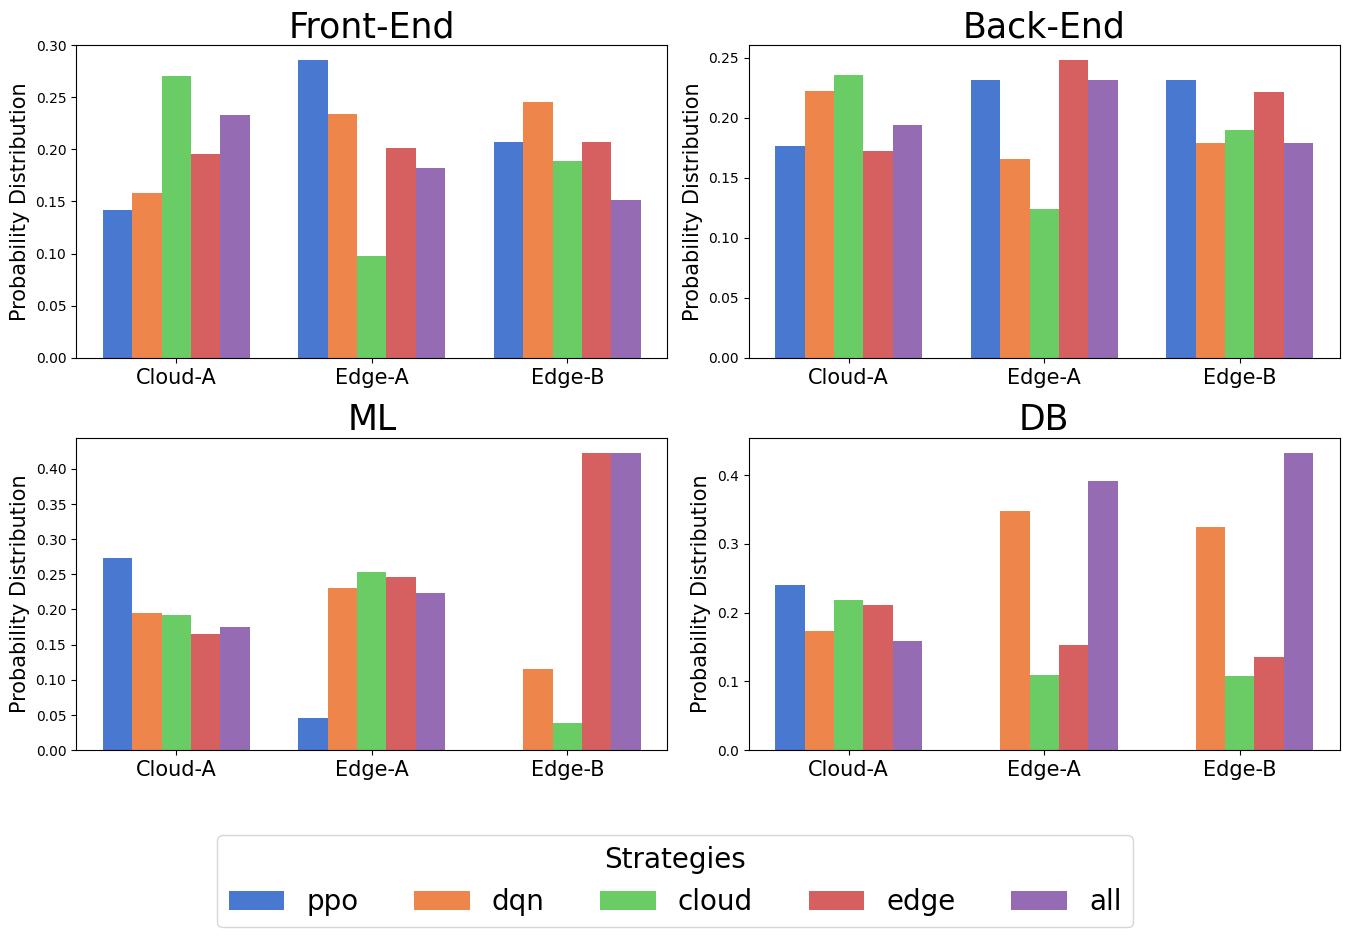

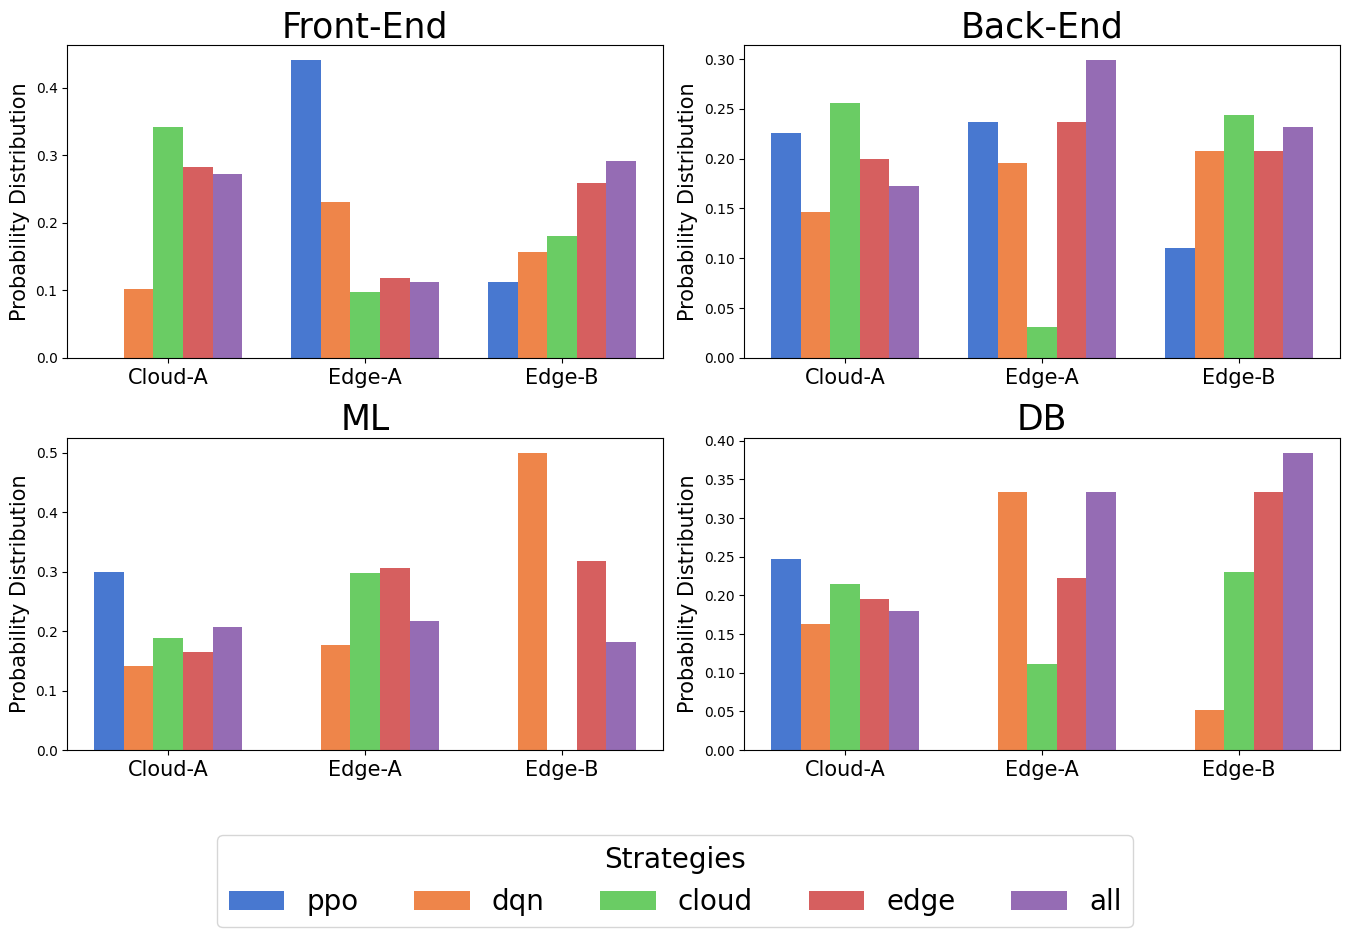

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

# 设置CSV文件所在的文件夹路径
be_data_path = './results/distribution/be'
rl_data_path = './results/distribution/rl'

# 定义要分析的MSA应用
msa_applications = ['aggregator_sequential', 'aggregator_parallel', 'chain']

# 定义要考虑的策略
be_strategies = ['all', 'cloud', 'edge']
rl_strategies = ['ppo', 'dqn']
all_strategies = ['ppo', 'dqn', 'cloud', 'edge', 'all']  # 固定顺序

# 定义要考虑的服务
services = ['aggregator', 'detection', 'ml', 'db']

# 指定要处理的replica编号列表
replica_numbers = [5]  # 可以根据需要调整为 [1], [2, 3], 等

# 初始化字典来存储结果
msa_data = {msa: {strategy: [] for strategy in all_strategies} for msa in msa_applications}

# 遍历文件夹中的文件
def read_files_from_path(data_path, strategies, msa_data, replicas):
    for file_name in os.listdir(data_path):
        # 检查文件名中是否包含指定的replica编号
        if file_name.endswith('.csv') and any(f'replica{r}' in file_name for r in replicas):
            # 判断是链类型
            if "chain" in file_name:
                msa = "chain"
                strategy = file_name.split('_')[1]
            else:
                # 提取MSA和策略
                parts = file_name.split('_')
                msa = f"{parts[0]}_{parts[1]}"
                strategy = parts[2]
            
            # 检查是否是我们关注的策略
            if msa in msa_applications and strategy in strategies:
                # 读取CSV文件时限制为前26行
                df = pd.read_csv(os.path.join(data_path, file_name), nrows=20)
                # 对所有列求和以获取该文件的Pod分布总和
                column_sums = df.sum().to_dict()
                
                # 将结果添加到对应的MSA和策略中
                msa_data[msa][strategy].append(column_sums)

# 读取be和rl文件夹中的数据
read_files_from_path(be_data_path, be_strategies, msa_data, replica_numbers)
read_files_from_path(rl_data_path, rl_strategies, msa_data, replica_numbers)

# 聚合所有副本的数据
aggregated_data = {}
for msa, strategy_data in msa_data.items():
    aggregated_data[msa] = {service: {vm_type: {strategy: 0 for strategy in all_strategies} for vm_type in set()} for service in services}
    for strategy, data_list in strategy_data.items():
        for data in data_list:
            for vm, count in data.items():
                # 从列名中提取服务名称
                service = vm.split('_')[0]
                # 提取VM类型，例如 edge_2, cloud_8
                vm_parts = vm.split('_')
                vm_type = f"{vm_parts[1]}_{vm_parts[2]}"
                if service in services:
                    if vm_type not in aggregated_data[msa][service]:
                        aggregated_data[msa][service][vm_type] = {strategy: 0 for strategy in all_strategies}
                    aggregated_data[msa][service][vm_type][strategy] += count

# 计算概率分布
for msa, service_data in aggregated_data.items():
    for service, vm_data in service_data.items():
        for vm_type, strategy_counts in vm_data.items():
            total_pods = sum(strategy_counts.values())
            if total_pods > 0:
                for strategy in all_strategies:
                    strategy_counts[strategy] /= total_pods


service_name_map = {'aggregator': 'Front-End', 'detection': 'Back-End', 'ml': 'ML', 'db': 'DB'}
# 绘制图表
for msa, service_data in aggregated_data.items():
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))  # 调整subgraph的大小
    # Map services to subplot positions (2x2 grid)
    service_positions = {'aggregator': (0, 0), 'detection': (0, 1), 'ml': (1, 0), 'db': (1, 1)}
    
    for service, vm_data in service_data.items():
        ax = axs[service_positions[service]]
        # Prepare data for plotting
        node_types = list(vm_data.keys())
        bar_width = 0.15
        x = np.arange(len(node_types))
        
        # 使用sns的muted palette
        palette = sns.color_palette("muted",len(all_strategies))
        
        # Plot each strategy as a grouped bar chart
        for idx, strategy in enumerate(all_strategies):
            strategy_probs = [vm_data[node][strategy] for node in node_types]
            ax.bar(x + idx * bar_width, strategy_probs, bar_width, label=strategy, color=palette[idx])
        
        # Configure axis
        ax.set_title(f'{service_name_map[service]}', fontsize=25)  # 调整label大小
        # ax.set_xlabel('Node Types', fontsize=20)  # 调整label大小
        ax.set_ylabel('Probability Distribution', fontsize=15)  # 调整label大小
        # 设置xlabel, 将cloud_8映射成Cloud-A
        ax.set_xticks(x + bar_width * (len(all_strategies) - 1) / 2)
        node_types = ["Cloud-A", "Edge-A", "Edge-B"]
        ax.set_xticklabels(node_types, fontsize=15)  # 调整label大小

    # 添加全局图例
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Strategies', loc='lower center', ncol=len(all_strategies), fontsize=20, title_fontsize=20)

    plt.tight_layout(rect=[0, 0.15, 0.85, 0.95])
    plt.savefig(f'./output/distribution/distribution_{msa}.png')
    plt.show()


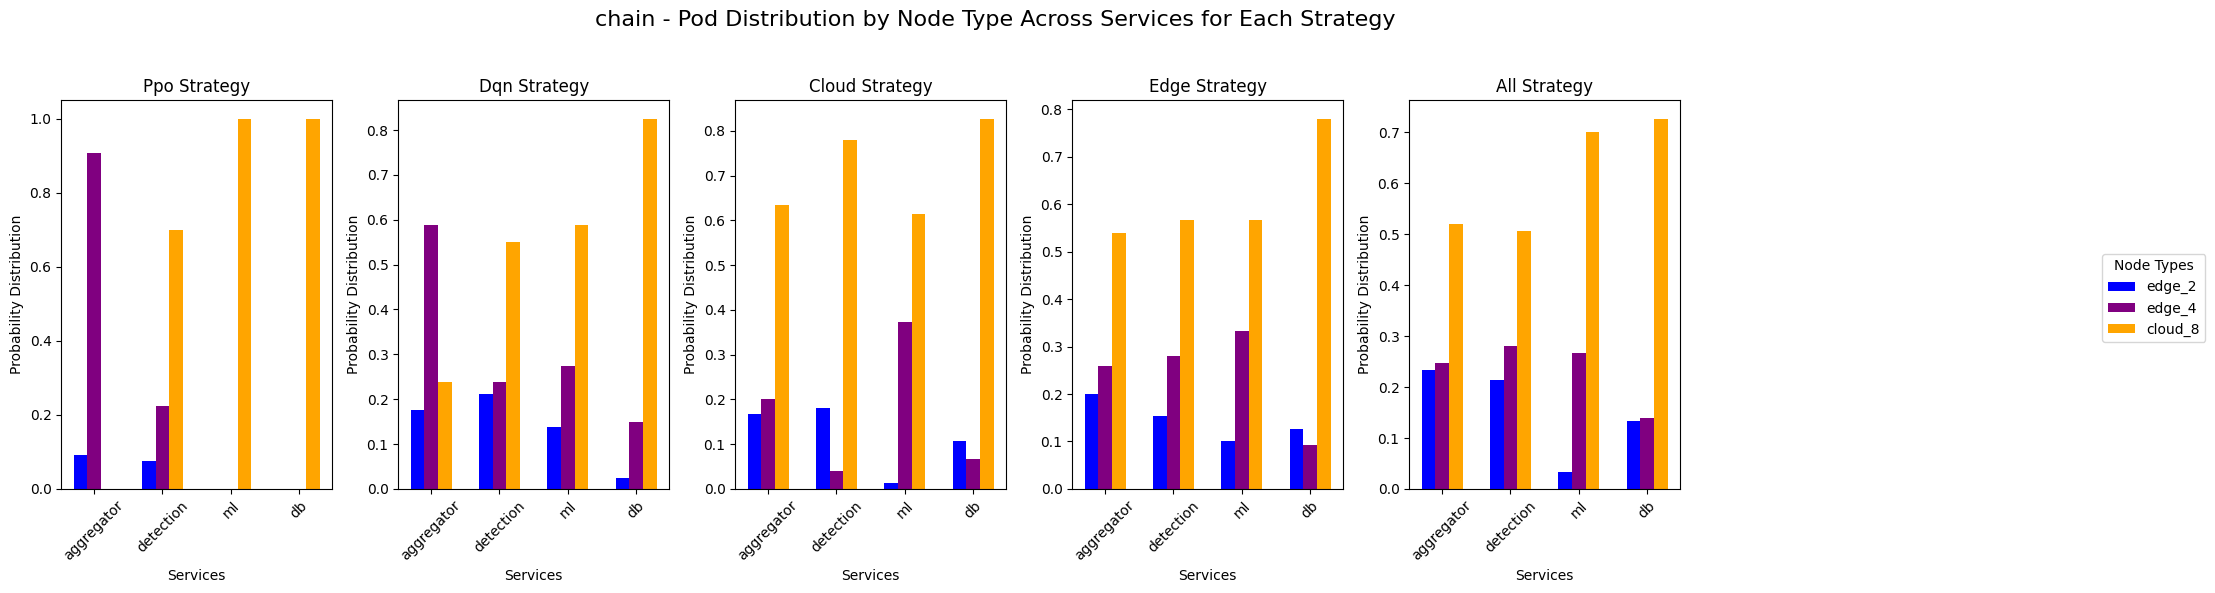

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# 设置CSV文件所在的文件夹路径
be_data_path = './results/distribution/be'
rl_data_path = './results/distribution/rl'

# 定义要分析的MSA应用
msa_applications = ['chain']

# 定义要考虑的策略
be_strategies = ['all', 'cloud', 'edge']
rl_strategies = ['ppo', 'dqn']
all_strategies = ['ppo', 'dqn', 'cloud', 'edge', 'all']  # 固定顺序

# 定义要考虑的服务
services = ['aggregator', 'detection', 'ml', 'db']

# 指定要处理的replica编号列表
replica_numbers = [5]  # 可以根据需要调整为 [1], [2, 3], 等

# 初始化字典来存储结果
msa_data = {msa: {strategy: [] for strategy in all_strategies} for msa in msa_applications}

# 遍历文件夹中的文件
def read_files_from_path(data_path, strategies, msa_data, replicas):
    for file_name in os.listdir(data_path):
        # 检查文件名中是否包含指定的replica编号
        if file_name.endswith('.csv') and any(f'replica{r}' in file_name for r in replicas):
            # 判断是链类型
            if "chain" in file_name:
                msa = "chain"
                strategy = file_name.split('_')[1]
            else:
                # 提取MSA和策略
                parts = file_name.split('_')
                msa = f"{parts[0]}_{parts[1]}"
                strategy = parts[2]
            
            # 检查是否是我们关注的策略
            if msa in msa_applications and strategy in strategies:
                # 读取CSV文件时限制为前26行
                df = pd.read_csv(os.path.join(data_path, file_name))
                
                # 对所有列求和以获取该文件的Pod分布总和
                column_sums = df.sum().to_dict()
                
                # 将结果添加到对应的MSA和策略中
                msa_data[msa][strategy].append(column_sums)

# 读取be和rl文件夹中的数据
read_files_from_path(be_data_path, be_strategies, msa_data, replica_numbers)
read_files_from_path(rl_data_path, rl_strategies, msa_data, replica_numbers)

# 聚合所有副本的数据
aggregated_data = {}
for msa, strategy_data in msa_data.items():
    aggregated_data[msa] = {service: {strategy: defaultdict(int) for strategy in all_strategies} for service in services}
    for strategy, data_list in strategy_data.items():
        for data in data_list:
            for vm, count in data.items():
                # 从列名中提取服务名称
                service = vm.split('_')[0]
                # 提取VM类型，例如 edge_2, cloud_8
                vm_parts = vm.split('_')
                vm_type = f"{vm_parts[1]}_{vm_parts[2]}"
                if service in services:
                    aggregated_data[msa][service][strategy][vm_type] += count

# 计算概率分布
for msa, service_data in aggregated_data.items():
    for service, strategy_data in service_data.items():
        for strategy, vm_distribution in strategy_data.items():
            total_pods = sum(vm_distribution.values())
            if total_pods > 0:
                for vm_type in vm_distribution:
                    vm_distribution[vm_type] /= total_pods

# 绘制图表
color_map = {
    'edge_2': 'blue', 'edge_4': 'purple', 'cloud_8': 'orange'
}
for msa, service_data in aggregated_data.items():
    fig, axs = plt.subplots(1, 5, figsize=(20, 6))
    fig.suptitle(f'{msa} - Pod Distribution by Node Type Across Services for Each Strategy', fontsize=16)
    
    for idx, strategy in enumerate(all_strategies):
        ax = axs[idx]
        # Prepare data for plotting
        service_names = services
        bar_width = 0.2
        x = np.arange(len(service_names))
        
        # For each service, plot the VM distribution for the current strategy
        for vm_type in color_map.keys():
            vm_values = [aggregated_data[msa][service][strategy].get(vm_type, 0) for service in services]
            ax.bar(x + list(color_map.keys()).index(vm_type) * bar_width, vm_values, bar_width, label=vm_type, color=color_map[vm_type])
        
        # Configure axis
        ax.set_title(f'{strategy.capitalize()} Strategy')
        ax.set_xlabel('Services')
        ax.set_ylabel('Probability Distribution')
        ax.set_xticks(x + bar_width)
        ax.set_xticklabels(service_names, rotation=45)
    
    # 添加全局图例
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Node Types', bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()
